# *Import Libraries*


In [1]:
import os
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from skimage.feature import hog
from skimage.transform import pyramid_gaussian
import imutils
from imutils.object_detection import non_max_suppression


import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

# *Create dataset*

In [2]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset'

faces_path = os.path.join(dataset_path, 'faces')
no_faces_path = os.path.join(dataset_path, 'No_faces')

print(f'Path faces: {faces_path} - Exists:{os.path.exists(faces_path)}')
print(f'Path No faces: {no_faces_path} - Exists: {os.path.exists(no_faces_path)}')

Path faces: /content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/faces - Exists:True
Path No faces: /content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/No_faces - Exists: True


In [3]:
if os.path.exists(faces_path) and os.path.exists(no_faces_path):
  faces_image = os.listdir(faces_path)
  no_faces_image = os.listdir(no_faces_path)

  print(f'Number of faces: {len(faces_image)}')
  print(f'Number of No faces: {len(no_faces_image)}')

Number of faces: 400
Number of No faces: 400


# *HOG Feature Extractor*

In [8]:
# HOG feature extractor
def hog_extractor(image):

  '''
    Extracts HOG (Histogram of Oriented Gradients) features from a greyscale image.

    Parameters:
    ----------
    image : ndarray
        Greyscale image (grayscale) from which to extract HOG features.

    Returns:
    ------------
    features : ndarray
        Vector of HOG features extracted from the image.

    hog_image : ndarray
        Displayable HOG image, useful for debugging or displaying detected gradients.

    '''
  features, hog_image = hog(image,
                              orientations=9,
                              pixels_per_cell=(8,8),
                              cells_per_block=(2,2),
                              visualize=True,
                              block_norm = 'L2-Hys')

  return features, hog_image

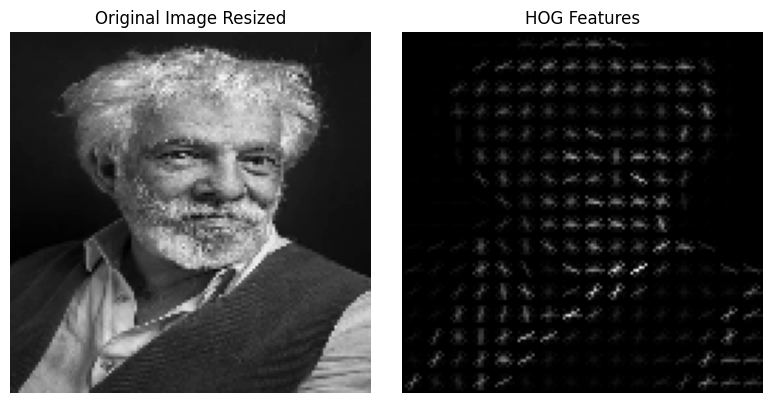


Shape image: (128, 128)
Shape HOG: (8100,)


In [9]:
#read, grayscale and resize image
img_path = (os.path.join(faces_path, os.listdir(faces_path)[5]))
img = cv.imread(img_path)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
resized_img = cv.resize(gray, (128, 128))

#HOG extraction
features, hog_img = hog_extractor(resized_img)

# Original image
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(resized_img, cmap='gray')
plt.title('Original Image Resized')
plt.axis('off')

# HOG image
plt.subplot(1,2,2)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Features')
plt.axis('off')
plt.tight_layout()
plt.show()

#shape image
print(f'\nShape image: {resized_img.shape}')
print(f'Shape HOG: {features.shape}')

In [10]:
#create list
X = []
y = []

#Load faces and assign label = 1
for i, filename in enumerate(os.listdir(faces_path)):
    img_path = os.path.join(faces_path, filename)
    img = cv.imread(img_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized = cv.resize(gray, (128, 128))
    features, _ = hog_extractor(resized)
    X.append(features)
    y.append(1)

#Load no_faces and assign label = 0
for i, filename in enumerate(os.listdir(no_faces_path)):
    img_path = os.path.join(no_faces_path, filename)
    img = cv.imread(img_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized = cv.resize(gray, (128, 128))
    features, _ = hog_extractor(resized)
    X.append(features)
    y.append(0)

# transforming Feature(X) and Label(y) into array numpy
X = np.array(X)
y = np.array(y)

In [11]:
print('\nInformation about dataset:')
print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')
print(f'Class Distribution: {np.bincount(y)}')
print(f'Percentage faces: {np.sum(y == 1)/ len(y) * 100:.2f}%')
print(f'Percentage no faces: {np.sum(y == 0)/ len(y) * 100:.2f}%')


Information about dataset:
Shape X: (800, 8100)
Shape y: (800,)
Class Distribution: [400 400]
Percentage faces: 50.00%
Percentage no faces: 50.00%


In [13]:
def visualize_examples(faces_path, no_faces_path, num_examples=3):

  '''
  Display some examples of face and non-face

  INPUT:
  faces_path: path to reach face image
  no_faces_path: path to reach No_face image
  num_examples: number of example to show

  '''

  plt.figure(figsize=(12, 4))

  # Visualize 3 examples for faces images
  for i in range(num_examples):
      if i < len(os.listdir(faces_path)):
          img_path = os.path.join(faces_path, os.listdir(faces_path)[i])
          img = cv.imread(img_path)
          img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
          plt.subplot(2, num_examples, i+1)
          plt.imshow(img)
          plt.title(f'Face #{i+1}')
          plt.axis('off')

    # Visualize 3 examples for no faces images
  for i in range(num_examples):
      if i < len(os.listdir(no_faces_path)):
          img_path = os.path.join(no_faces_path, os.listdir(no_faces_path)[i])
          img = cv.imread(img_path)
          img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
          plt.subplot(2, num_examples, num_examples+i+1)
          plt.imshow(img)
          plt.title(f'No Face #{i+1}')
          plt.axis('off')

  plt.tight_layout()
  plt.show()

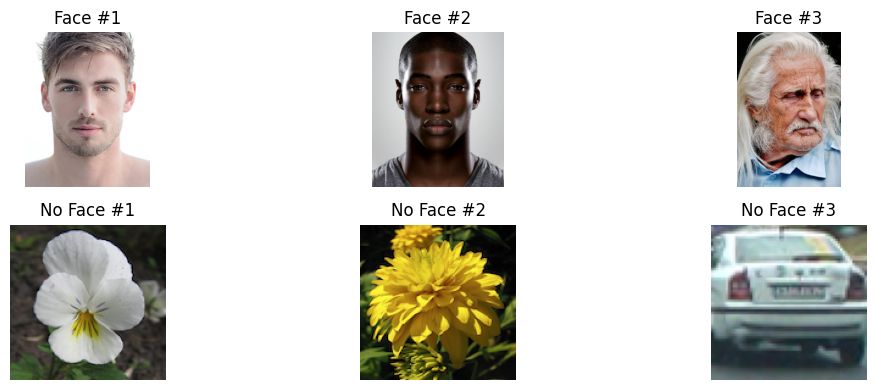


Dataset creation completed


In [14]:
visualize_examples(faces_path, no_faces_path)
print('\nDataset creation completed')

# *Split Train and Test*

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set: {X_train.shape[0]}, {y_train.shape}')
print(f'Test set: {X_test.shape[0]}')

Training set: 640, (640,)
Test set: 160


# *Train Model*

In [16]:
svm = SVC(kernel="linear",
          probability=True,
          random_state=42)

svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [17]:
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9313


In [18]:
print(f'Classification Report:\n',classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93        80
           1       0.95      0.91      0.93        80

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



# *Confusion Matrix*

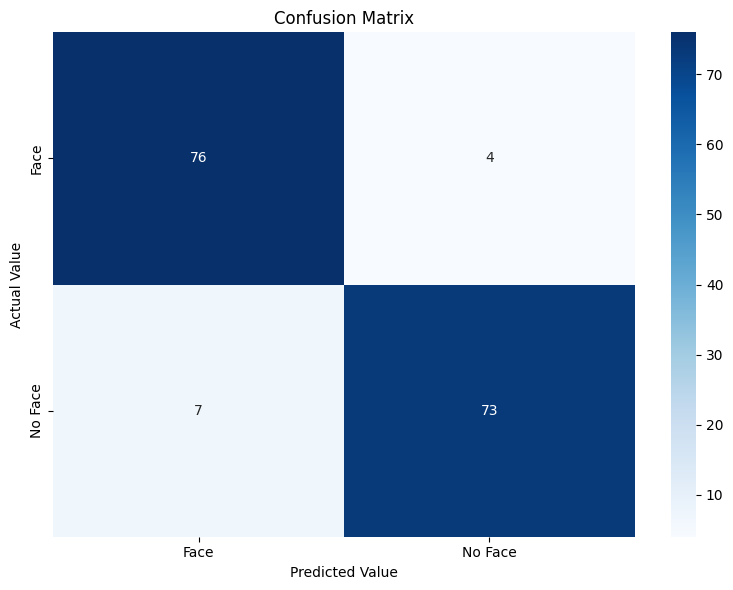

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Face', 'No Face'],
            yticklabels=['Face', 'No Face'])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

The SVM algorithm is widely used in machine learning due to its ability to handle both linear and non-linear classification tasks. However, when the data is not linearly separable, kernel functions are used to transform the data into a multidimensional space, enabling linear separation. This application of kernel functions is known as "kernel trick", and the choice of kernel function, such as linear kernel, polynomial kernel, RBF (Radial Basis Function) kernel or sigmoid kernel, depends on the characteristics of the data and the specific use case.

In this case the SVM model reach 93% of accuracy score.

The confusione matrix:
* True Positive: 76
* False Negative: 4
* False Positive: 7
* True Negative: 73


# *Fine Tuning and Save Best Model*

In [20]:
#tuning
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel':['rbf', 'linear']
}

In [21]:
random_search = RandomizedSearchCV(svm,
                                   param_distributions=param_distributions,
                                   n_iter=10,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=SVC(kernel='linear', probability=True,
                                 random_state=42),
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1, 1],
                                        'kernel': ['rbf', 'linear']},
                   random_state=42, scoring='accuracy')

In [22]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_:.4f}')

Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best score: 0.9422


In [23]:
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best:.4f}')

Best Model Accuracy: 0.9500


In [24]:
svm_model = best_model

In [25]:
print('\n--- Saving model ---')

model_filename = 'face_detector_svm.pkl'


--- Saving model ---


In [26]:
with open(model_filename, 'wb') as file:
    pickle.dump(svm_model, file)

print(f"Model saved as '{model_filename}'")

Model saved as 'face_detector_svm.pkl'


# *Image Pyramid*

In [27]:
def image_pyramid(image, scale=1.2, minSize=(30,30)):
    '''
    Create a pyramid of images at different scales

    INPUT:
    image:  image to use
    scale: scaling at each ‘pyramid floor’
    minSize: minimum dimensions required (width and height) to stop pyramid construction
    '''
    yield image

    while True:
        new_width = int(image.shape[1] / scale)
        image = imutils.resize(image, width=new_width)


        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        yield image

# *Sliding Window*

In [30]:
def sliding_window(image, stepSize, windowSize):

    '''
    Implements a sliding window on the image

    INPUT:
    image: image to use
    stepSize: quantity shifted at the creation of each window, for both x and y
    windowSize: heigth and width window (larghezza ed altezza)
    '''

    # shift windows on image
    for y in range(0, image.shape[0] - windowSize[1] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[0] + 1, stepSize):
            yield (x, y, image[y:y+windowSize[1], x:x+windowSize[0]])

In [31]:
def detect_faces(image, model, hog_extractor, step_size=16, window_size=(128, 128), scale=1.2, threshold=0.95):

    """
    Detects faces in an image using an SVM model and sliding window + image pyramid.

    Args:
        image: original image (BGR)
        model: svm model trained
        hog_extractor: function custom HOG
        step_size: step sliding window
        window_size: dimension of window
        scale: pyramid scale
        threshold: trheshold probability to detect face or no faces

    Returns:
        image_with_boxes: image with bounding boxes around detected faces
        boxes: list of bounding box detected (x, y, x+w, y+h)
    """

    original_image = image.copy()
    #Initialize the list of boxes
    boxes = []

    for resized_image in image_pyramid(image, scale=scale, minSize=window_size):
        scale_factor = image.shape[1] / float(resized_image.shape[1])

        for (x, y, window) in sliding_window(resized_image, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue

            gray = cv.cvtColor(window, cv.COLOR_BGR2GRAY)
            features, _ = hog_extractor(gray)
            features = np.array(features).reshape(1, -1)

            prob = best_model.predict_proba(features)[0][1]

            if prob >= threshold:
                x_orig = int(x * scale_factor)
                y_orig = int(y * scale_factor)
                w_orig = int(window_size[0] * scale_factor)
                h_orig = int(window_size[1] * scale_factor)

                boxes.append((x_orig, y_orig, x_orig + w_orig, y_orig + h_orig))
                cv.rectangle(original_image, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (0, 255, 0), 2)

    return original_image, boxes


# *Test # 1*

Coordinates bounding boxes found: [(160, 16, 288, 144), (176, 16, 304, 144), (144, 112, 272, 240), (160, 112, 288, 240), (176, 112, 304, 240), (272, 112, 400, 240), (160, 128, 288, 256), (176, 128, 304, 256), (272, 128, 400, 256), (288, 128, 416, 256), (160, 144, 288, 272), (176, 144, 304, 272), (272, 144, 400, 272), (288, 144, 416, 272), (160, 160, 288, 288), (272, 160, 400, 288), (288, 160, 416, 288), (96, 224, 224, 352), (192, 240, 320, 368), (192, 256, 320, 384), (208, 256, 336, 384), (144, 272, 272, 400), (153, 96, 306, 249), (173, 96, 326, 249), (269, 96, 422, 249), (134, 115, 287, 268), (153, 115, 306, 268), (269, 115, 422, 268), (288, 115, 441, 268), (134, 134, 287, 287), (153, 134, 306, 287), (269, 134, 422, 287), (288, 134, 441, 287), (153, 153, 306, 306), (269, 153, 422, 306), (192, 230, 345, 383), (211, 230, 364, 383), (192, 249, 345, 402), (134, 269, 287, 422), (138, 23, 322, 207), (138, 46, 322, 230), (253, 46, 437, 230), (138, 69, 322, 253), (161, 69, 345, 253), (230, 69

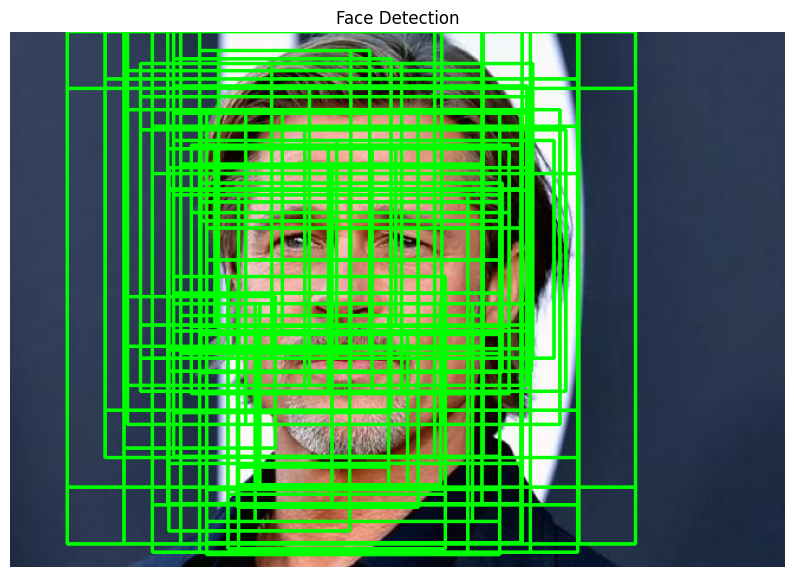

In [32]:
image = cv.imread("/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/BP-kCEC-U3180547664485cqD-656x492@Corriere-Web-Sezioni.jpeg")
output_image, detected_boxes = detect_faces(image, svm_model, hog_extractor)

print("Coordinates bounding boxes found:", detected_boxes)

output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(output_image_rgb)
plt.title('Face Detection')
plt.axis('off')
plt.show()

The function reveal a lot of boxes.
We need to define NMS (Non Max Suppression) to eliminate redundant overlapping bounding boxes

In [33]:
def non_max_suppression(boxes, probs=None, overlap_thresh=0.3):
    '''
    Applies Non-Maximum Suppression (NMS) to eliminate overlapping and redundant bounding boxes.

    Parameters:
    ----------
    boxes : ndarray
        Array of bounding boxes in the format [x1, y1, x2, y2].

    probs : ndarray, optional
        Probabilities associated with each bounding box (used to order the boxes if available).

    overlap_thresh : float, optional
        Overlap threshold (IoU) above which boxes are considered redundant
        and therefore eliminated. Default: 0.3.

    Returns:
    ------------
    ndarray
        The bounding boxes remaining after the application of NMS.

    '''
    if len(boxes) == 0:
        return []

    # Convert boxes to numpy array if they're not already
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # Initialize the list of picked indexes
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes and sort by probabilities
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs) if probs is not None else np.argsort((y2 - y1) * (x2 - x1))

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest coordinates for the start of the bounding box and
        # the smallest coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have overlap greater than the threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick].astype("int")

# *Build new function with NMS and Test # 2*

In [34]:
def detect_faces_improved(image, model, hog_extractor, step_size=16, window_size=(128, 128), scale=1.2, threshold=0.98, overlap_thresh=0.3):

    """
    Enhanced face detection via HOG + SVM, with support for image pyramid and Non-Maximum Suppression (NMS).

    Parameters:
    ----------
    image : ndarray
        Original BGR image in which to search for faces.

    model : sklearn.svm.SVC
        SVM model trained with HOG feature, supporting `predict_proba`.

    hog_extractor : function
        Function which extracts HOG features from a greyscale image.

    step_size : int, optional
        Step size of the sliding window. Default: 16.

    window_size : tuple, optional
        Size of the scanning window (width, height). Default: (128, 128).

    scale : float, optional
        Scale factor for each level of the image pyramid. Default: 1.2.

    threshold : float, optional
        Minimum probability threshold for a window to be considered a face. Default: 0.98.

    overlap_thresh : float, optional
        Threshold for Non-Maximum Suppression (NMS). Default: 0.3.

    Returns:
    ------------
    output_image : ndarray
        Copy of the original image with bounding boxes drawn.

    final_boxes : list of list
        List of coordinates of the final bounding boxes in the format [x1, y1, x2, y2].
    """

    original_image = image.copy()
    boxes = []
    probs = []  # Track probabilities for better NMS

    for resized_image in image_pyramid(image, scale=scale, minSize=window_size):
        scale_factor = image.shape[1] / float(resized_image.shape[1])

        for (x, y, window) in sliding_window(resized_image, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue

            gray = cv.cvtColor(window, cv.COLOR_BGR2GRAY)
            features, _ = hog_extractor(gray)
            features = np.array(features).reshape(1, -1)

            prob = model.predict_proba(features)[0][1]

            if prob >= threshold:
                x_orig = int(x * scale_factor)
                y_orig = int(y * scale_factor)
                w_orig = int(window_size[0] * scale_factor)
                h_orig = int(window_size[1] * scale_factor)

                boxes.append([x_orig, y_orig, x_orig + w_orig, y_orig + h_orig])
                probs.append(prob)

    # Apply NMS if we found any boxes
    if len(boxes) > 0:
        boxes_array = np.array(boxes)
        probs_array = np.array(probs)
        final_boxes = non_max_suppression(boxes_array, probs_array, overlap_thresh)

        # Draw the final boxes
        for (x1, y1, x2, y2) in final_boxes:
            cv.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        return original_image, final_boxes.tolist()

    return original_image, []

Coordinates bounding boxes found: [[96, 48, 481, 433]]


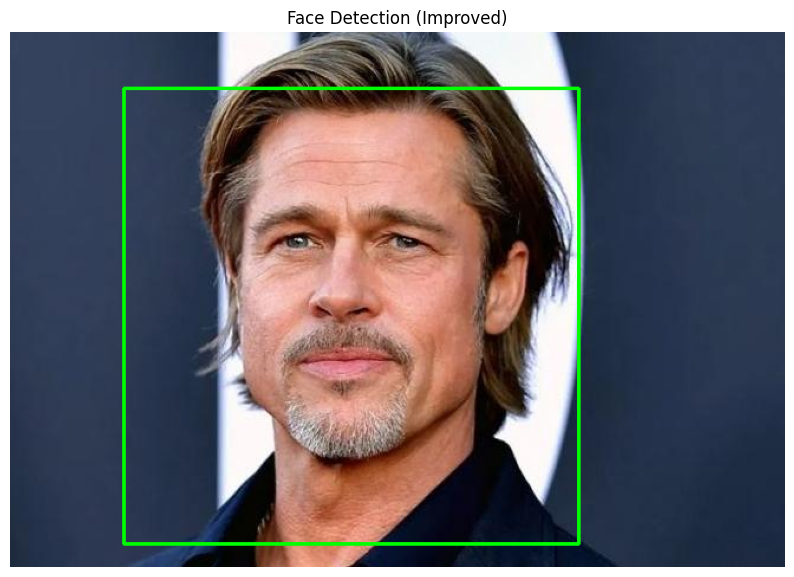

In [35]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/BP-kCEC-U3180547664485cqD-656x492@Corriere-Web-Sezioni.jpeg')
output_image, detected_boxes = detect_faces_improved(image, svm_model, hog_extractor)

print('Coordinates bounding boxes found:', detected_boxes)

#cast BGR to RGB to visualize with matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

#plot to visualize results
plt.figure(figsize=(10, 8))
plt.imshow(output_image_rgb)
plt.title("Face Detection (Improved)")
plt.axis("off")
plt.show()

Coordinates bounding boxes found: [[268, 0, 421, 153], [240, 112, 368, 240], [172, 38, 325, 191]]


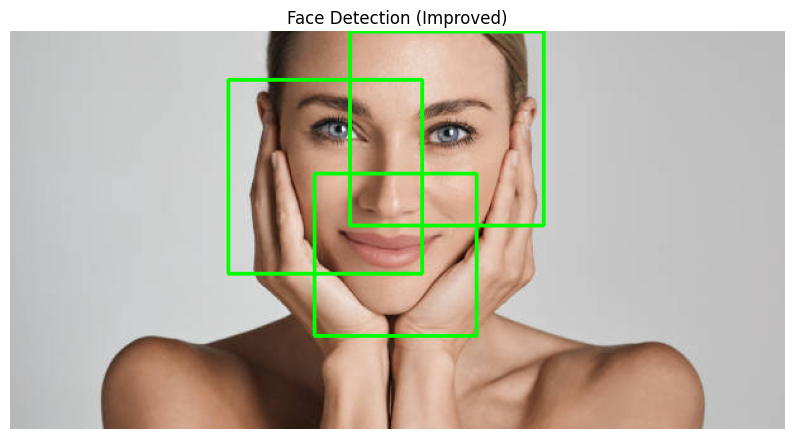

In [36]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/istockphoto-1406728194-612x612.jpg')

output_image, detected_boxes = detect_faces_improved(image, svm_model, hog_extractor)

print('Coordinates bounding boxes found:', detected_boxes)

#cast BGR to RGB to visualize with matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

#plot to visualize results
plt.figure(figsize=(10, 8))
plt.imshow(output_image_rgb)
plt.title("Face Detection (Improved)")
plt.axis("off")
plt.show()

Coordinates bounding boxes found: [[0, 96, 128, 224], [432, 96, 560, 224], [320, 96, 448, 224], [96, 96, 224, 224], [208, 96, 336, 224], [38, 0, 191, 153], [208, 0, 336, 128]]


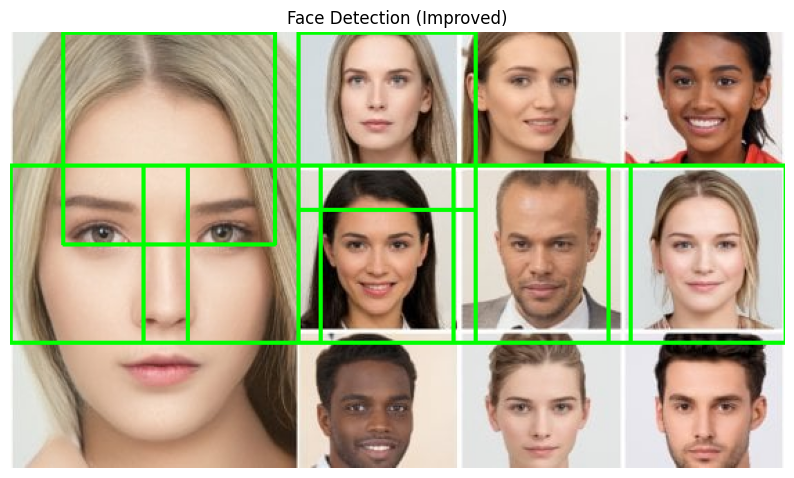

In [37]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/103741003-198ba3db-6d15-400f-9046-371a6213ecd9.jpg')

output_image, detected_boxes = detect_faces_improved(image, svm_model, hog_extractor)

print('Coordinates bounding boxes found:', detected_boxes)

#cast BGR to RGB to visualize with matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

#plot to visualize results
plt.figure(figsize=(10, 8))
plt.imshow(output_image_rgb)
plt.title("Face Detection (Improved)")
plt.axis("off")
plt.show()

Coordinates bounding boxes found: [[221, 27, 442, 248], [115, 211, 268, 364]]


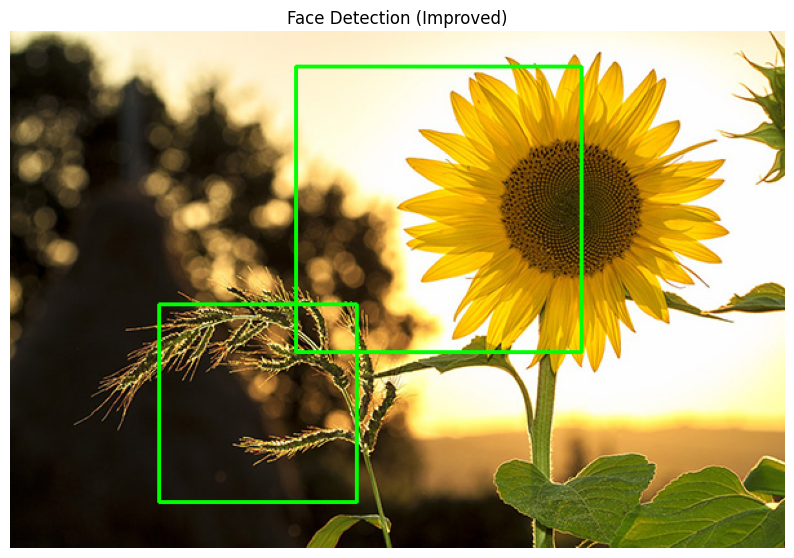

In [38]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/sunflower.jpg')

output_image, detected_boxes = detect_faces_improved(image, svm_model, hog_extractor)

print('Coordinates bounding boxes found:', detected_boxes)

#cast BGR to RGB to visualize with matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

#plot to visualize results
plt.figure(figsize=(10, 8))
plt.imshow(output_image_rgb)
plt.title("Face Detection (Improved)")
plt.axis("off")
plt.show()

Coordinates bounding boxes found: []


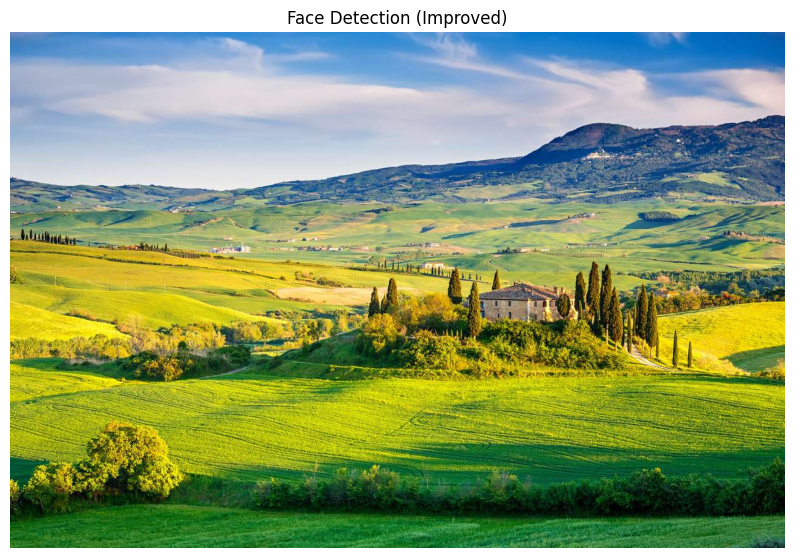

In [39]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/noface_face_dataset/paesaggio.jpg')

output_image, detected_boxes = detect_faces_improved(image, svm_model, hog_extractor)

print('Coordinates bounding boxes found:', detected_boxes)

#cast BGR to RGB to visualize with matplotlib
output_image_rgb = cv.cvtColor(output_image, cv.COLOR_BGR2RGB)

#plot to visualize results
plt.figure(figsize=(10, 8))
plt.imshow(output_image_rgb)
plt.title("Face Detection (Improved)")
plt.axis("off")
plt.show()

# Final Conclusion

The model seems to be very accurate when analysing only images of faces, without any external noise.

In the second image, hands, shoulders and arms appear, which probably confuses the model a little, as it finds three bounding boxes near the face.

In the third image, the model shows many bounding boxes, possibly due to the multitude of faces in one image.


---


The sunflowers image is a very intresting case:

the model recognises it as a face and is most likely fooled by the silhouette of the flower, which appears to be very similar to the images of the faces it was trained with.
Perhaps to avoid this the model could also be trained on the recognition of skin textures.


---



Materials:
* https://docs.opencv.org/3.4/d7/dbd/group__imgproc.html
* https://pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/
* https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
* https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/
* https://pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
* https://cvexplained.wordpress.com/2020/07/14/2-3-2-sliding-windows/
* https://docs.opencv.org/3.4/d7/dbd/group__imgproc.html
* https://www.youtube.com/watch?v=S64sTZSGMY4&list=PLZF-BxqUQCorKJN2_8NtX8qKZddf1UqOi&ab_channel=DataTrader
